In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [52]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids, plot_res_gp, my_plot_convergence
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_mobattrs_26_data_provider import PriceHistoryMobAttrs26DataProvider
from data_providers.price_history_dataset_generator import PriceHistoryDatasetGenerator
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from models.price_history_mobattrs_26 import PriceHistoryMobAttrs26
from gp_opt.price_history_26_gp_opt import PriceHistory26GpOpt
from os.path import isdir
from cost_functions.huber_loss import huber_loss

In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [4]:
input_len = 60
target_len = 30

batch_size = 100
with_EOS = False

In [5]:
full_train_size = 46000
train_size = 7000 #just because of performance reasons, no statistics behind this decision
test_size = 11500

### Once generate data

In [6]:
data_folder = '../../../../Dropbox/data'
assert isdir(data_folder)

In [7]:
ph_data_path = data_folder + '/price_history'
assert isdir(ph_data_path)

In [8]:
#npz_path = ph_data_path + '/price_history_mobattrs_dp_60to30_57994_trimmed'
#assert path.isfile(npz_path + '_train.npz')
#assert path.isfile(npz_path + '_test.npz')
npz_path = ph_data_path + '/price_history_mobattrs_dp_60to30_57994_trimmed_small'
assert path.isfile(npz_path + '_train.npz')

In [9]:
npz_train = npz_path + '_train.npz'

In [10]:
# PriceHistoryDatasetGenerator.create_subsampled(random_state=random_state,
#     inpath=npz_path + '_train.npz', target_size=7000, outpath=npz_path + '_small_train.npz')

### Step 1 - collect data

In [11]:
dp = PriceHistoryMobAttrs26DataProvider(npz_path=npz_path, batch_size=batch_size, with_EOS=with_EOS)
for data in dp.datalist:
    print data.shape

(7000, 60, 1)
(7000, 139)
(7000, 30)


In [12]:
aa, bb, cc = dp.next()
aa.shape, bb.shape, cc.shape

((100, 60, 1), (100, 139), (100, 30))

### Step 2 - Build model

In [13]:
model = PriceHistoryMobAttrs26(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [14]:
graph = model.getGraph(batch_size=batch_size,
                       num_units = 10,
                       rnn_hidden_dim = 20,
                       mobile_attrs_dim = 30,
                       input_len=input_len,
                       target_len=target_len)

60
Tensor("inputs/unstack:0", shape=(100, 1), dtype=float32)

Tensor("encoder_rnn_layer/rnn/gru_cell_59/add:0", shape=(100, 10), dtype=float32)

time
Tensor("decoder_rnn_layer/rnn/while/add:0", shape=(), dtype=int32)

readout inputs
Tensor("decoder_rnn_layer/rnn/while/readout_input:0", shape=(100, 50), dtype=float32)

readout
Tensor("decoder_rnn_layer/rnn/while/readout:0", shape=(100, 1), dtype=float32)

decoder_final_loop_state
Tensor("decoder_rnn_layer/rnn/while/Exit_5:0", shape=(100, 30), dtype=float32)

Tensor("error/Select:0", shape=(100, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)
Tensor("error/Mean:0", shape=(), dtype=float32)



In [15]:
show_graph(graph)

## Quick test run

In [16]:
def experiment():
    return model.run(npz_path=npz_path,
                     rnn_hidden_dim = 100,
                     mobile_attrs_dim = 100,
                     epochs=5,
                     batch_size = batch_size,
                     num_units = 500,
                     input_len=input_len,
                     target_len=target_len,
                     learning_rate = 1e-2,
                     preds_gather_enabled = False,
                     decoder_first_input = PriceHistoryMobAttrs26.DECODER_FIRST_INPUT.ZEROS,
                     keep_prob_input = 1.,
                     lamda2 = 0.,
                    )

In [17]:
#aa = experiment()

epochs: 5  
lamda2: 0.0  
learning_rate: 0.01  
keep_prob_input: 1.0  
num_units: 500  
End Epoch 01 (39.820 secs): err(train) = 0.232479, current dec_ins_percent_usage: 1.00  
End Epoch 02 (38.472 secs): err(train) = 0.005852, current dec_ins_percent_usage: 0.00  
End Epoch 03 (38.482 secs): err(train) = 0.004404, current dec_ins_percent_usage: 0.00  
End Epoch 04 (38.492 secs): err(train) = 0.004014, current dec_ins_percent_usage: 0.00  
End Epoch 05 (38.535 secs): err(train) = 0.003806, current dec_ins_percent_usage: 0.00  

# Cross Validating

In [26]:
bayes_opt_dir = data_folder + '/bayes_opt'

In [18]:
def plotter(stats_list, label_text):
    _ = renderStatsListWithLabels(stats_list=stats_list, label_text=label_text)
    plt.show()

    _ = renderStatsListWithLabels(stats_list=stats_list, label_text=label_text,
                                  title='Validation Error', kk='error(valid)')
    plt.show()

In [21]:
obj = PriceHistory26GpOpt(model=model,
                          stats_npy_filename = 'bayes_opt_26_stats_dic',
                          cv_score_dict_npy_filename = 'bayes_opt_26_cv_scores_dic',
                          res_gp_filename = 'bayes_opt_26_res_gp',
                          random_state=random_state,
                          plotter = plotter,
                          npz_path=npz_path,
                          epochs=15,
                          batch_size=batch_size,
                          input_len=input_len,
                          target_len=target_len,
                          n_splits=5,
                          bayes_opt_dir = bayes_opt_dir
                         )

In [22]:
opt_res = obj.run_opt(n_random_starts=2, n_calls=17)

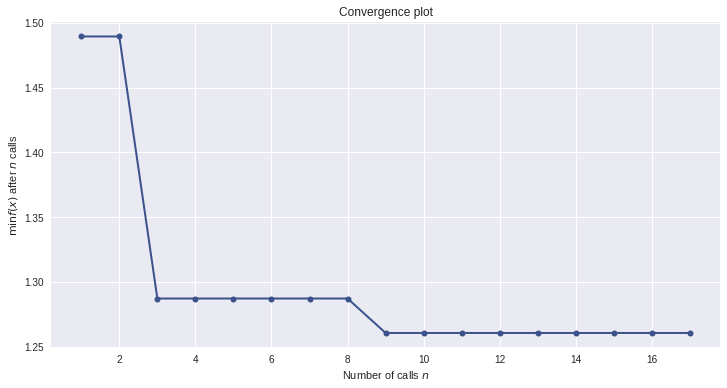

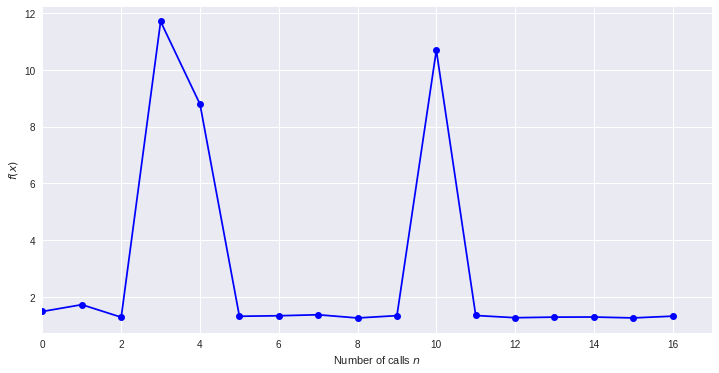

In [23]:
plot_res_gp(opt_res)

In [24]:
opt_res.best_params

[650,
 1.0000000000000001e-05,
 0.20000000000000001,
 0.00081953012182350653,
 320,
 515]

In [27]:
filepath = bayes_opt_dir + '/bayes_opt_26_stats_dic.npy'

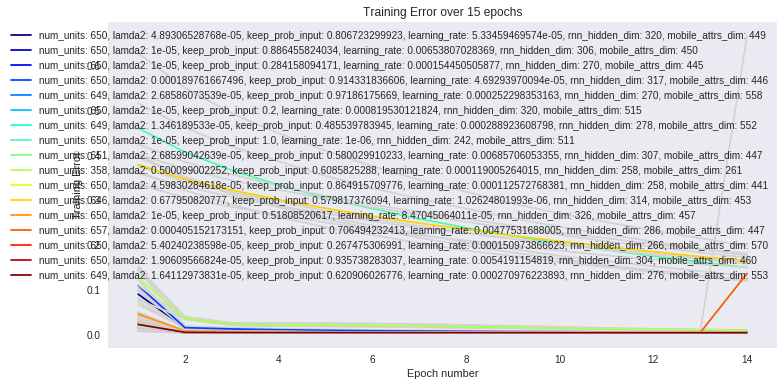

In [28]:
renderStatsCollectionOfCrossValids(stats_dic=np.load(filepath)[()], label_texts=[
    'num_units', 'lamda2', 'keep_prob_input', 'learning_rate', 'rnn_hidden_dim', 'mobile_attrs_dim'])
plt.show()

In [30]:
best_params = opt_res.best_params

### Step 3 training the network

best params:

[650,
 1.0000000000000001e-05,
 0.20000000000000001,
 0.00081953012182350653,
 320,
 515]

In [31]:
if 'best_params' not in locals().keys():
    print "hardcoded"
    best_params = [650,
     1.0000000000000001e-05,
     0.20000000000000001,
     0.00081953012182350653,
     320,
     515]

In [32]:
model = PriceHistoryMobAttrs26(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [33]:
best_params

[650,
 1.0000000000000001e-05,
 0.20000000000000001,
 0.00081953012182350653,
 320,
 515]

In [34]:
num_units, lamda2, keep_prob_input, learning_rate, rnn_hidden_dim, mobile_attrs_dim = best_params

In [35]:
batch_size

100

In [36]:
npz_path = ph_data_path + '/price_history_mobattrs_dp_60to30_57994_trimmed'
assert path.isfile(npz_path + '_train.npz')
assert path.isfile(npz_path + '_test.npz')

In [40]:
def experiment():
    return model.run(epochs=100,
                     npz_path=npz_path,
                     rnn_hidden_dim = rnn_hidden_dim,
                     mobile_attrs_dim = mobile_attrs_dim,
                     batch_size = batch_size,
                     num_units = num_units,
                     input_len=input_len,
                     target_len=target_len,
                     learning_rate = learning_rate,
                     preds_gather_enabled = True,
                     decoder_first_input = PriceHistoryMobAttrs26.DECODER_FIRST_INPUT.ZEROS,
                     keep_prob_input = keep_prob_input,
                     lamda2 = lamda2,
                    )

In [39]:
#%%time
dyn_stats, preds_dict, targets = get_or_run_nn(experiment, filename='026_price_history_mobattrs_60to30_001',
                                              nn_runs_folder= data_folder + '/nn_runs')

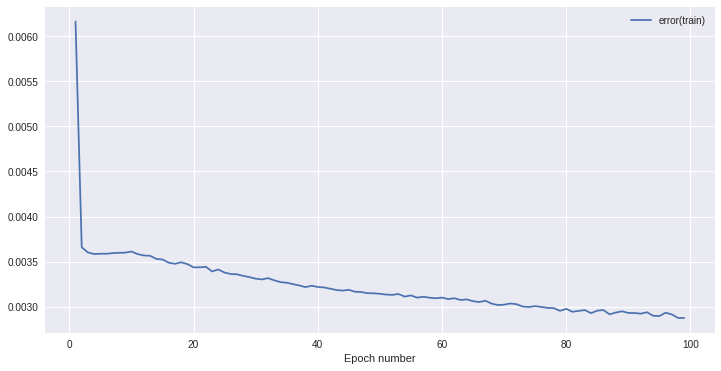

In [41]:
dyn_stats.plotStats()
plt.show()

In [42]:
r2_scores = [r2_score(y_true=targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(targets))]

In [43]:
ind = np.argmin(r2_scores)
ind

10392

In [44]:
reals = targets[ind]
preds = preds_dict[ind]

In [45]:
r2_score(y_true=reals, y_pred=preds)

-4.3888685925504794e+31

In [46]:
#sns.tsplot(data=dp.inputs[ind].flatten())

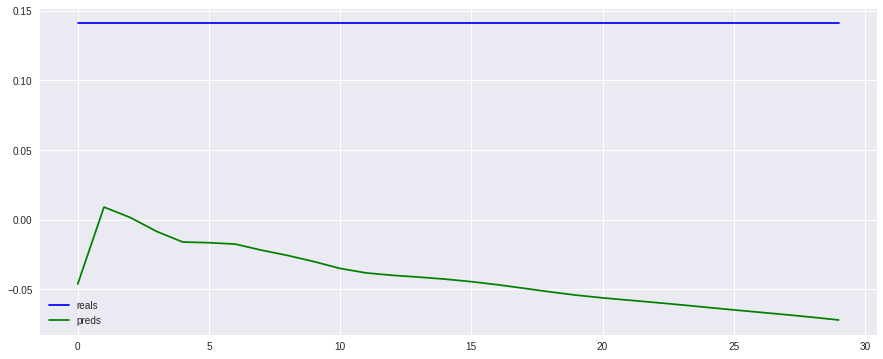

In [47]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [48]:
%%time
dtw_scores = [fastdtw(targets[ind], preds_dict[ind])[0]
             for ind in range(len(targets))]

CPU times: user 24.1 s, sys: 180 ms, total: 24.3 s
Wall time: 24.1 s


In [49]:
np.mean(dtw_scores)

1.1704436078458655

In [50]:
coint(preds, reals)

(1.2576190371020795, 1.0, array([-4.31395736, -3.55493606, -3.19393252]))

In [53]:
average_huber_loss = np.mean([np.mean(huber_loss(targets[ind], preds_dict[ind]))
                              for ind in range(len(targets))])
average_huber_loss

0.0031484411761876817

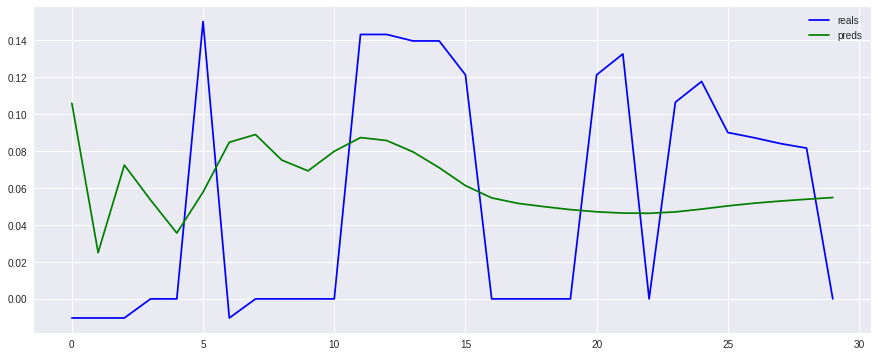

In [59]:
cur_ind = np.random.randint(len(targets))
reals = targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

### Conclusion
???